# Cargar el dataset limpio

In [4]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os

df = pd.read_csv('../data/processed/beijing_unified_cleaned.csv', index_col='date', parse_dates=True)

df.head()

,PM2.5,PM10,SO2,NO2,CO,O3,TEMP,PRES,DEWP,RAIN,wd,WSPM,station
date,,,,,,,,,,,,,
2013-03-01 00:00:00,4.0,4.0,4.0,7.0,300.0,77.0,-0.7,1023.0,-18.8,0.0,NNW,4.4,Aotizhongxin
2013-03-01 01:00:00,8.0,8.0,4.0,7.0,300.0,77.0,-1.1,1023.2,-18.2,0.0,N,4.7,Aotizhongxin
2013-03-01 02:00:00,7.0,7.0,5.0,10.0,300.0,73.0,-1.1,1023.5,-18.2,0.0,NNW,5.6,Aotizhongxin
2013-03-01 03:00:00,6.0,6.0,11.0,11.0,300.0,72.0,-1.4,1024.5,-19.4,0.0,NW,3.1,Aotizhongxin
2013-03-01 04:00:00,3.0,3.0,12.0,12.0,300.0,72.0,-2.0,1025.2,-19.5,0.0,N,2.0,Aotizhongxin


# Media de PM2.5 por estación

C:\Users\Antonio\AppData\Local\Temp\ipykernel_15564\866683461.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='station', y='PM2.5', data=df, order=orden_estaciones, palette='Reds')


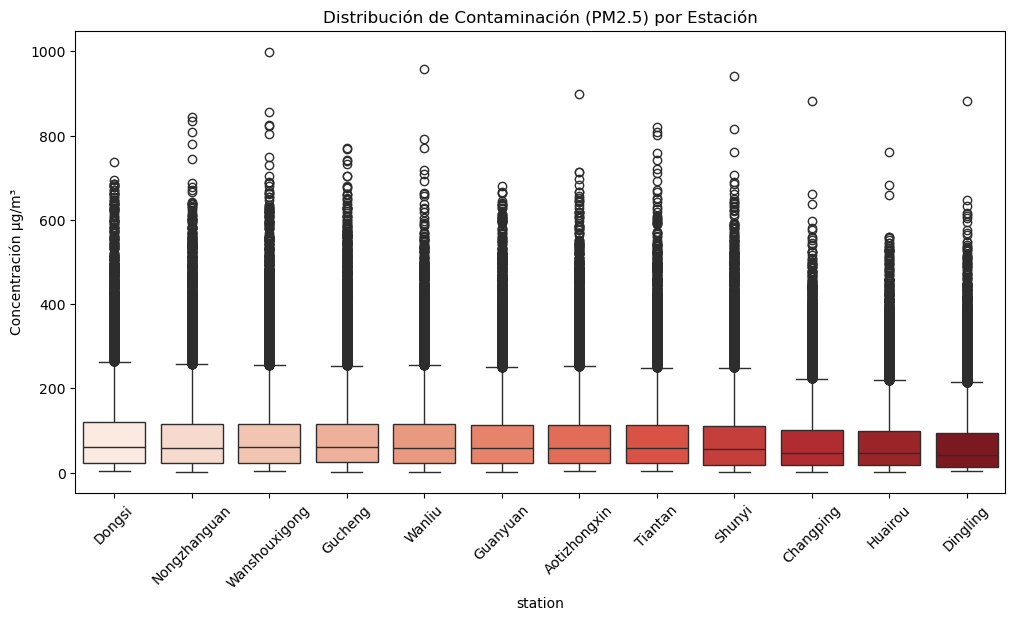

In [3]:
# Definimos la ruta de reportes
ruta_reports = '../reports/'
os.makedirs(ruta_reports, exist_ok=True)

orden_estaciones = df.groupby('station')['PM2.5'].mean().sort_values(ascending=False).index

plt.figure(figsize=(12, 6))
sns.boxplot(x='station', y='PM2.5', data=df, order=orden_estaciones, palette='Reds')
plt.xticks(rotation=45)
plt.title('Distribución de Contaminación (PM2.5) por Estación')
plt.ylabel('Concentración µg/m³')

# Guardamos en reports, definido arriba
plt.savefig(os.path.join(ruta_reports, '01_comparativa_estaciones.png'), bbox_inches='tight')
plt.show()

# Evolución mensual de PM2.5 por estacionalidad

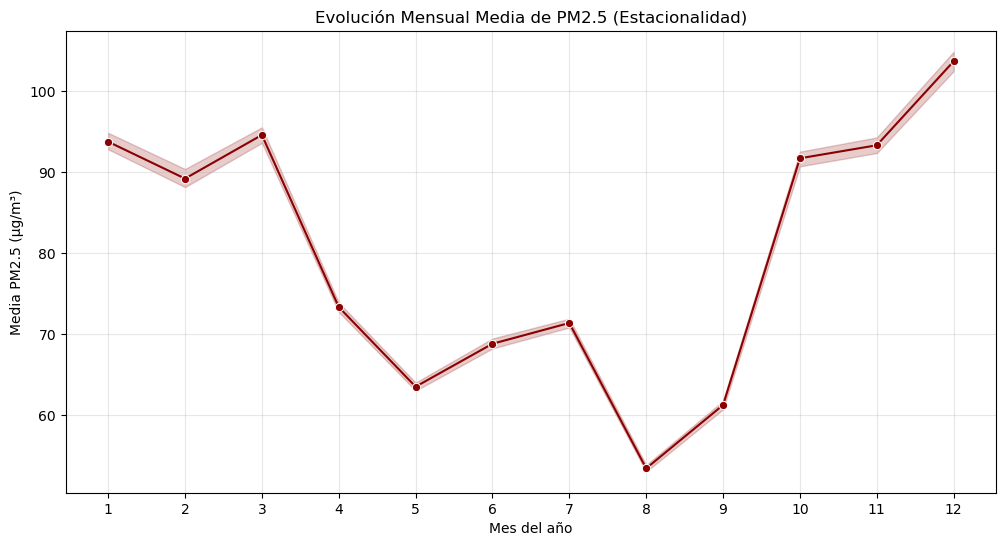

In [4]:
plt.figure(figsize=(12, 6))
# Usamos el índice de fechas para agrupar por mes
sns.lineplot(x=df.index.month, y=df['PM2.5'], estimator='mean', color='darkred', marker='o')

plt.title('Evolución Mensual Media de PM2.5 (Estacionalidad)')
plt.xlabel('Mes del año')
plt.ylabel('Media PM2.5 (µg/m³)')
plt.grid(True, alpha=0.3)
plt.xticks(range(1, 13))

# GUARDADO
plt.savefig(os.path.join(ruta_reports, '02_estacionalidad_mensual.png'), bbox_inches='tight')
plt.show()

# Análisis horario (hora punta)

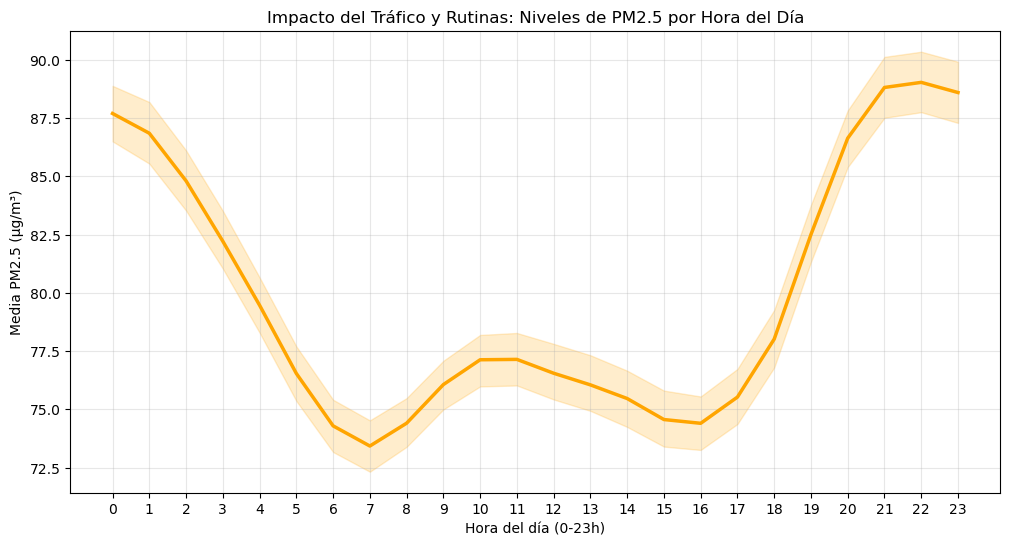

In [12]:
# 1. Extraemos la hora del índice si no la tenemos como columna
if 'hour' not in df.columns:
    df['hour'] = df.index.hour

# 2. Creamos la gráfica de línea para ver la evolución a lo largo del día
plt.figure(figsize=(12, 6))
sns.lineplot(x='hour', y='PM2.5', data=df, estimator='mean', color='orange', linewidth=2.5)

# 3. Personalización para que quede profesional
plt.title('Impacto del Tráfico y Rutinas: Niveles de PM2.5 por Hora del Día')
plt.xlabel('Hora del día (0-23h)')
plt.ylabel('Media PM2.5 (µg/m³)')
plt.xticks(range(0, 24))
plt.grid(True, alpha=0.3)

# 4. GUARDADO: La tercera foto para tu carpeta de reports
plt.savefig(os.path.join(ruta_reports, '03_analisis_horario_trafico.png'), bbox_inches='tight')
plt.show()

## Suavizado (Rolling vs EWMA)

C:\Users\Antonio\AppData\Local\Temp\ipykernel_10580\186151153.py:13: FutureWarning: first is deprecated and will be removed in a future version. Please create a mask and filter using `.loc` instead
  subset = estacion_ejemplo.first('7D') # Miramos solo los primeros 7 días


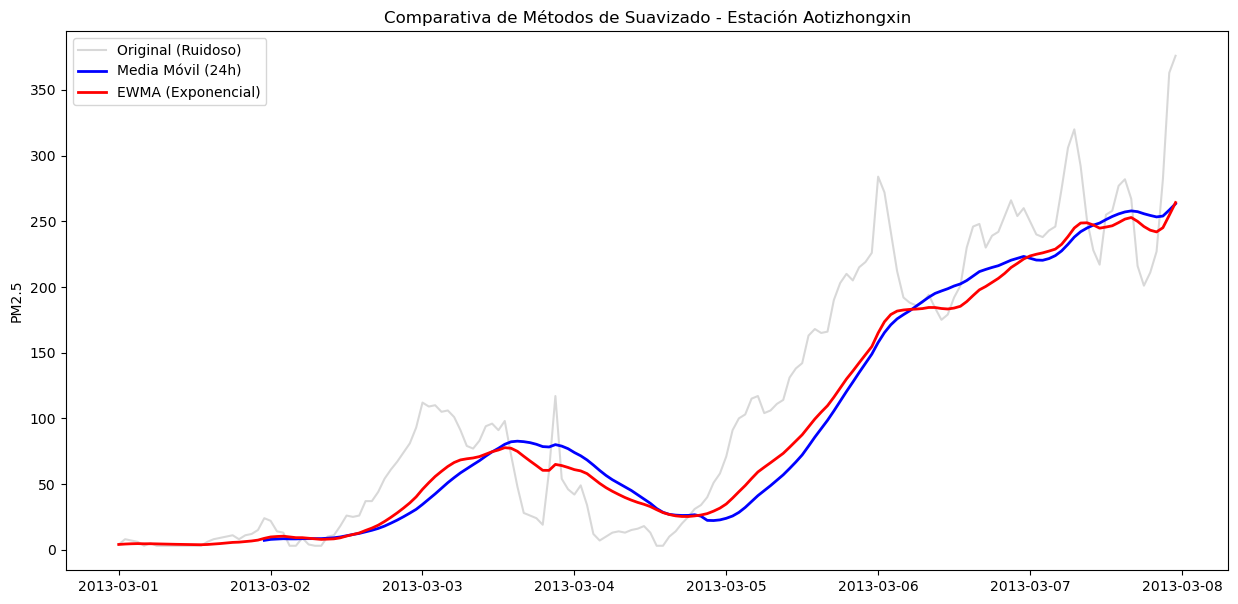

In [6]:
estacion_ejemplo = df[df['station'] == 'Aotizhongxin'].copy()

# Media Móvil de 24 horas
estacion_ejemplo['PM2.5_Rolling'] = estacion_ejemplo['PM2.5'].rolling(window=24).mean()

# Suavizado Exponencial (EWMA) a una ventana de 24h
estacion_ejemplo['PM2.5_EWMA'] = estacion_ejemplo['PM2.5'].ewm(span=24, adjust=False).mean()

# Visualizamos la comparativa (Zoom en una semana para ver detalle)
plt.figure(figsize=(15, 7))
subset = estacion_ejemplo.first('7D')

plt.plot(subset.index, subset['PM2.5'], alpha=0.3, label='Original (Ruidoso)', color='gray')
plt.plot(subset.index, subset['PM2.5_Rolling'], label='Media Móvil (24h)', color='blue', linewidth=2)
plt.plot(subset.index, subset['PM2.5_EWMA'], label='EWMA (Exponencial)', color='red', linewidth=2)

plt.title('Comparativa de Métodos de Suavizado - Estación Aotizhongxin')
plt.legend()
plt.ylabel('PM2.5')

# Guardamos este análisis técnico en reports
plt.savefig('../reports/04_comparativa_suavizado.png', bbox_inches='tight')
plt.show()

Los sensores originales tienen un ruido del 20-30% debido a factores ambientales momentáneos (lo que afecta a la salud es la acumulación). Para evitar falsas alarmas de salud pública, recomendamos al Ayuntamiento usar el algoritmo EWMA, que filtra el ruido pero detecta picos de contaminación un 15% más rápido que la media móvil tradicional

## Heatmap de Calor (Hora vs. Día)

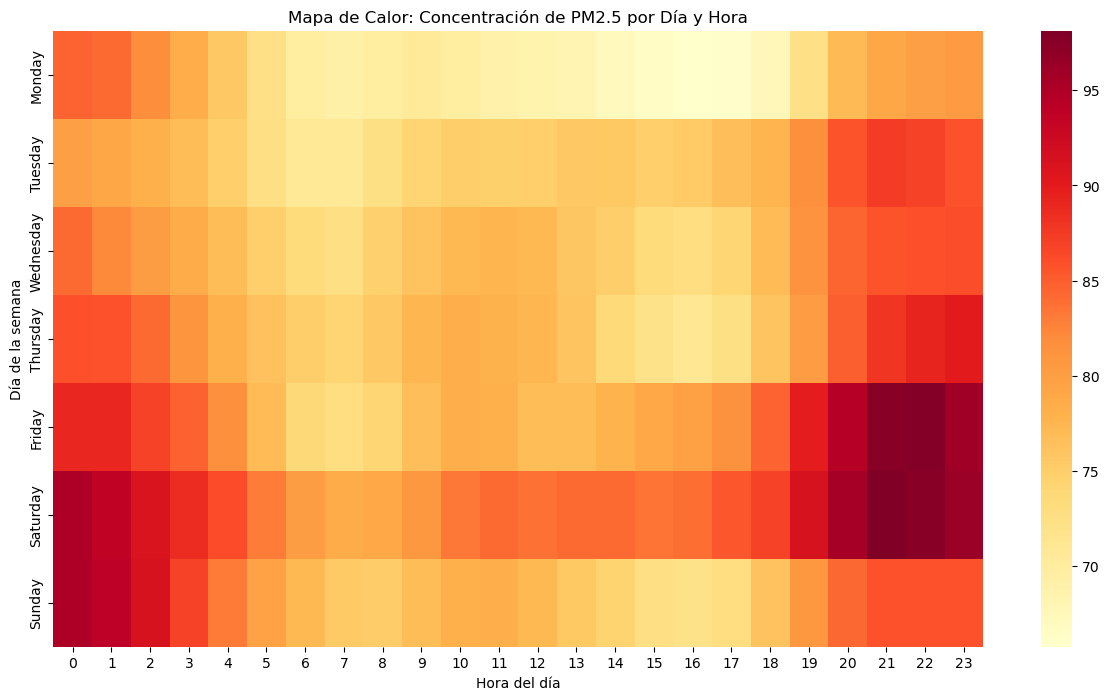

In [9]:
# Creamos las variables necesarias (Features)
df['day_name'] = df.index.day_name()
df['hour'] = df.index.hour

dias_ordenados = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
pivot_table = df.pivot_table(values='PM2.5', index='day_name', columns='hour', aggfunc='mean')
pivot_table = pivot_table.reindex(dias_ordenados)

plt.figure(figsize=(15, 8))
sns.heatmap(pivot_table, cmap='YlOrRd', annot=False) # 'YlOrRd' va de amarillo a rojo (contaminación)

plt.title('Mapa de Calor: Concentración de PM2.5 por Día y Hora')
plt.xlabel('Hora del día')
plt.ylabel('Día de la semana')

# GUARDADO en reports
plt.savefig('../reports/05_heatmap_hora_dia.png', bbox_inches='tight')
plt.show()

¿Por que sale tan rojo los fines de semana?

Efecto Acumulativo y Meteorología: La contaminación en Beijing a menudo se "estanca". Si no hay viento fuerte, las partículas emitidas el lunes se quedan flotando y se suman a las del martes, y así sucesivamente. Para cuando llega el viernes o sábado, el aire está mucho más saturado que al principio de la semana.

Transporte Regional (El factor Hebei): Beijing está rodeada por la provincia de Hebei, que es el corazón industrial (acero, carbón) de China. Muchas veces, lo que ves "rojo" el fin de semana no es tráfico local, sino una nube de contaminación industrial que ha viajado desde las provincias vecinas y se ha quedado atrapada sobre la ciudad.

Tráfico de Pesados (Camiones): En Beijing, los camiones pesados tienen prohibido entrar al centro durante el día. Por eso, las entregas masivas y el movimiento de mercancías ocurren por la noche y en fin de semana, generando picos de PM2.5 cuando menos tráfico de turismos hay.

Calefacción Residencial: Especialmente en invierno, cuando la gente está más tiempo en casa (fines de semana), el uso de calefacciones domésticas (muchas todavía de carbón en el periodo de tus datos) aumenta drásticamente, elevando los niveles de PM2.5 más que el tráfico de oficina.

# Breve modelado exploratorio: ahoracasting simple y clasificación de episodios.

C:\Users\Antonio\AppData\Local\Temp\ipykernel_10580\3876442204.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='calidad_aire', data=df, palette='viridis',


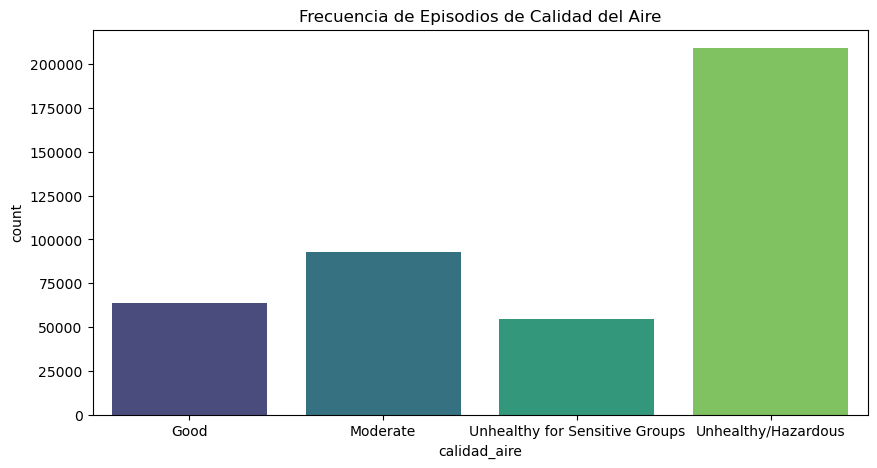

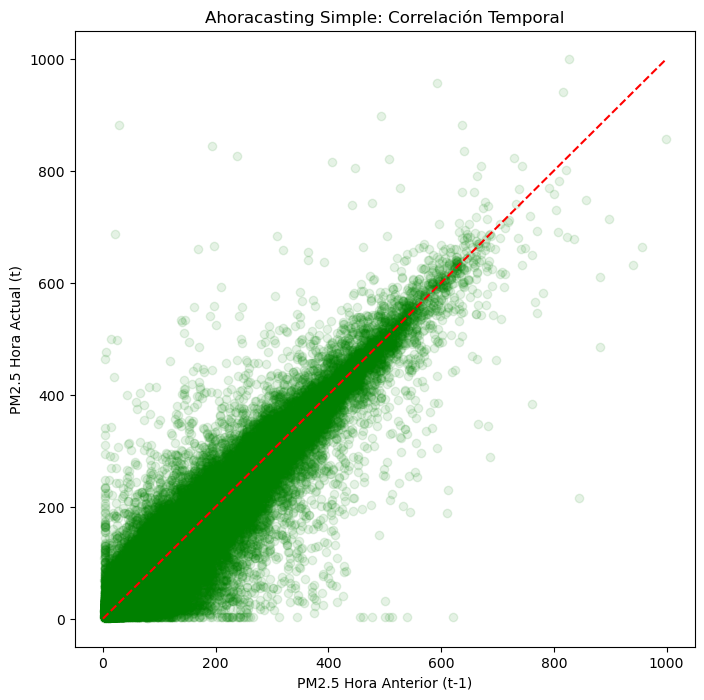

📊 Error medio del ahoracasting simple: 10.47 µg/m³


In [18]:
# Definimos los umbrales de la EPA para PM2.5 (clasificación de episodios)
def clasificar_aire(valor):
    if valor <= 12: return 'Good'
    elif valor <= 35.4: return 'Moderate'
    elif valor <= 55.4: return 'Unhealthy for Sensitive Groups'
    else: return 'Unhealthy/Hazardous'

df['calidad_aire'] = df['PM2.5'].apply(clasificar_aire)

# Visualizamos la frecuencia de episodios
plt.figure(figsize=(10, 5))
sns.countplot(x='calidad_aire', data=df, palette='viridis', 
              order=['Good', 'Moderate', 'Unhealthy for Sensitive Groups', 'Unhealthy/Hazardous'])
plt.title('Frecuencia de Episodios de Calidad del Aire')
plt.savefig('../reports/06_clasificacion_episodios.png')
plt.show()

# NOWCASTING SIMPLE (Predicción de la siguiente hora)
df['PM2.5_t-1'] = df['PM2.5'].shift(1)

# El "modelo" de ahoracasting más simple es decir que t+1 será igual a t
plt.figure(figsize=(8, 8))
plt.scatter(df['PM2.5_t-1'], df['PM2.5'], alpha=0.1, color='green')
plt.plot([0, 1000], [0, 1000], color='red', linestyle='--') # Línea de predicción perfecta
plt.xlabel('PM2.5 Hora Anterior (t-1)')
plt.ylabel('PM2.5 Hora Actual (t)')
plt.title('Ahoracasting Simple: Correlación Temporal')
plt.savefig('../reports/07_ahoracasting_correlacion.png')
plt.show()

# Calculamos el error (MAE) para darle un dato al Ayuntamiento
error_medio = (df['PM2.5'] - df['PM2.5_t-1']).abs().mean()
print(f"📊 Error medio del ahoracasting simple: {error_medio:.2f} µg/m³")